## Setup

Here, we simply import all libraries we will use.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb

In [2]:
class Config:
    pass

CONFIG = Config()
CONFIG.SEED = 1

In [3]:
# Reproducibility
random.seed(CONFIG.SEED)
np.random.seed(CONFIG.SEED)
torch.manual_seed(CONFIG.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset

In [4]:
data_length = 1000
sample_rate = 2e-6

# Load CSV Files
# TODO: Use numpy instead of pandas
I_sin_5k = pd.read_csv('data/raw/I(sin_5k_hiB).csv', header=None).iloc[:,1:data_length+1]
V_sin_5k = pd.read_csv('data/raw/V(sin_5k_hiB).csv', header=None).iloc[:,1:data_length+1]

I_tri_5k = pd.read_csv('data/raw/I(tri_5k_hiB).csv', header=None).iloc[:,1:data_length+1]
V_tri_5k = pd.read_csv('data/raw/V(tri_5k_hiB).csv', header=None).iloc[:,1:data_length+1]

I_trap_5k = pd.read_csv('data/raw/I(trap_5k_hiB).csv', header=None).iloc[:,1:data_length+1]
V_trap_5k = pd.read_csv('data/raw/V(trap_5k_hiB).csv', header=None).iloc[:,1:data_length+1]

I = pd.concat([I_sin_5k , I_tri_5k , I_trap_5k], ignore_index=True)
V = pd.concat([V_sin_5k , V_tri_5k , V_trap_5k], ignore_index=True)

In [5]:
# Compute scalograms
wave_name = 'cgau8'
total_scale = 30
fc = pywt.central_frequency(wave_name)
fmax = 10e3
cparam = (1 / sample_rate) / fmax * fc * total_scale
scales = cparam / np.arange(total_scale, 1, -1)

data_size = I.shape[0]
image_size = 24
scalogram = np.zeros([data_size, image_size, image_size])
for index, row in V.iterrows():
    cwtmatr, _ = pywt.cwt(row, scales, wave_name, sample_rate)
    scalogram[index] = resize(abs(cwtmatr), (image_size, image_size))
    if index % 100 == 0:
        print(f"Index {index} finished")

Index 0 finished
Index 100 finished
Index 200 finished
Index 300 finished
Index 400 finished
Index 500 finished
Index 600 finished
Index 700 finished
Index 800 finished
Index 900 finished
Index 1000 finished
Index 1100 finished
Index 1200 finished
Index 1300 finished
Index 1400 finished
Index 1500 finished
Index 1600 finished
Index 1700 finished
Index 1800 finished
Index 1900 finished
Index 2000 finished
Index 2100 finished
Index 2200 finished
Index 2300 finished
Index 2400 finished
Index 2500 finished
Index 2600 finished
Index 2700 finished
Index 2800 finished
Index 2900 finished
Index 3000 finished
Index 3100 finished
Index 3200 finished
Index 3300 finished
Index 3400 finished
Index 3500 finished
Index 3600 finished
Index 3700 finished
Index 3800 finished
Index 3900 finished


In [6]:
# Compute label
P = V * I
t = np.arange(0, (data_length-0.5) * sample_rate, sample_rate)
Loss_meas = np.trapz(P, t, axis=1) / (sample_rate * data_length)

In [7]:
in_tensors = torch.from_numpy(scalogram).view(-1, 1, 24, 24)
out_tensors = torch.from_numpy(Loss_meas).view(-1, 1)

In [8]:
dataset = torch.utils.data.TensorDataset(in_tensors, out_tensors)
train_size = int(0.6 * data_size)
valid_size = int(0.2 * data_size)
test_size = data_size - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TODO: We should probably standardize dataset.

## Neural Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            # nn.Dropout(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0),-1)
        x = self.fc_layers(x)
        return x

In [10]:
net = Net().double()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
# From https://discuss.pytorch.org/t/4325/9
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(net)

16417

## Training

In [12]:
wandb.init(project="MagNet")
wandb.watch(net)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


In [13]:
for epoch_i in range(1, 20+1):
    # Train for one epoch
    epoch_train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    # Compute Validation Loss
    with torch.no_grad():
        epoch_valid_loss = 0
        for inputs, labels in valid_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            epoch_valid_loss += loss.item()

    print(f"Epoch {epoch_i:2d} "
          f"Train {epoch_train_loss / len(train_dataset):.5f} "
          f"Valid {epoch_valid_loss / len(valid_dataset):.5f}")
    wandb.log({
        "train/loss": epoch_train_loss / len(train_dataset),
        "valid/loss": epoch_valid_loss / len(valid_dataset),
    })

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Epoch  1 Train 0.00009 Valid 0.00006
Epoch  2 Train 0.00005 Valid 0.00006
Epoch  3 Train 0.00006 Valid 0.00005
Epoch  4 Train 0.00005 Valid 0.00004
Epoch  5 Train 0.00004 Valid 0.00004
Epoch  6 Train 0.00005 Valid 0.00005
Epoch  7 Train 0.00004 Valid 0.00003
Epoch  8 Train 0.00004 Valid 0.00003
Epoch  9 Train 0.00004 Valid 0.00002
Epoch 10 Train 0.00003 Valid 0.00002
Epoch 11 Train 0.00003 Valid 0.00003
Epoch 12 Train 0.00003 Valid 0.00002
Epoch 13 Train 0.00003 Valid 0.00002
Epoch 14 Train 0.00003 Valid 0.00002
Epoch 15 Train 0.00003 Valid 0.00002
Epoch 16 Train 0.00003 Valid 0.00002
Epoch 17 Train 0.00003 Valid 0.00004
Epoch 18 Train 0.00003 Valid 0.00003
Epoch 19 Train 0.00003 Valid 0.00002
Epoch 20 Train 0.00002 Valid 0.00002


## Evaluation

In [14]:
net.eval()
y_meas = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        y_pred.append(net(inputs))
        y_meas.append(labels)

y_meas = torch.cat(y_meas, dim=0)
y_pred = torch.cat(y_pred, dim=0)
print(f"Test Loss: {F.mse_loss(y_meas, y_pred) / len(test_dataset):.8f}")

Test Loss: 0.00000104


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


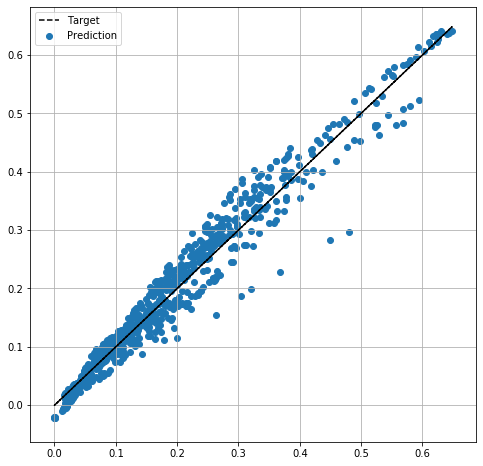

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 8)
ax.scatter(y_meas, y_pred, label="Prediction")
ax.plot(y_meas, y_meas, 'k--', label="Target")
ax.grid(True)
ax.legend()
wandb.log({"prediction_vs_target": wandb.Image(fig)})